In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import h5py
import lalsimulation as ls
import pandas as pd
from scipy.interpolate import interpn, interp1d
import seaborn as sns
from tqdm.notebook import tqdm

import sys

d = 'vt'
try:
    sys.path.index(d)
except ValueError:
    sys.path.append(d)
    
import vt

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

Let's look at our sensitivity to a 30-30 merger at design sensitivity:

In [3]:
vt_3030 = vt.vt_from_mass(30, 30, 8, 1.0, psd_fn=ls.SimNoisePSDaLIGOaLIGODesignSensitivityT1800044)
dC_range = cbrt(vt_3030/(4/3*pi))
print('Sensitive volume for 30-30 inspirals is {:.2f} Gpc^3, or a range of {:.2f} Gpc (comoving distance)'.format(vt_3030, dC_range))

Sensitive volume for 30-30 inspirals is 1.87 Gpc^3, or a range of 0.76 Gpc (comoving distance)


In [4]:
Tobs = 5 # Year
Ndet = 5000 # per Gpc^3 per year
n0 = Ndet/(vt_3030*Tobs)
print('Effective merger rate is {:.0f} Gpc^-3 yr^-1'.format(n0))

Effective merger rate is 536 Gpc^-3 yr^-1


In [68]:
r_bao = 100/0.7/1000 # Gpc
w_bao = 15/0.7/1000 # Gpc
A_bao = 0.01

def xi_bao(r):
    return A_bao*exp(-0.5*square(r-r_bao)/(w_bao*w_bao))

cutoff_scale = 5/0.7/1000 # Gpc
pl_factor = 5 # To reduce the overall variance

def xi_pl(r):
    r = np.atleast_1d(r)
    a = 1.8
    
    return np.where(r < cutoff_scale, 1 - a*(r-cutoff_scale)/cutoff_scale, (r/cutoff_scale)**(-a))*0.8/1.22/pl_factor

def xi(r):
    return xi_pl(r) + xi_bao(r)

print('BAO correlation length is {:.3f} Gpc'.format(r_bao))
print('Width of BAO Gaussian is {:.3f} Gpc'.format(w_bao))

BAO correlation length is 0.143 Gpc
Width of BAO Gaussian is 0.021 Gpc


In [69]:
def bao_covariance(xs):
    rvec = xs[newaxis,:,:] - xs[:,newaxis,:]
    rs = np.sqrt(np.sum(rvec*rvec, axis=2))
    xi_rs = xi(rs)
    
    return xi_rs

/Users/wfarr/anaconda3/envs/GWBAO/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in power
  from ipykernel import kernelapp as app


sigma 8 = 0.16


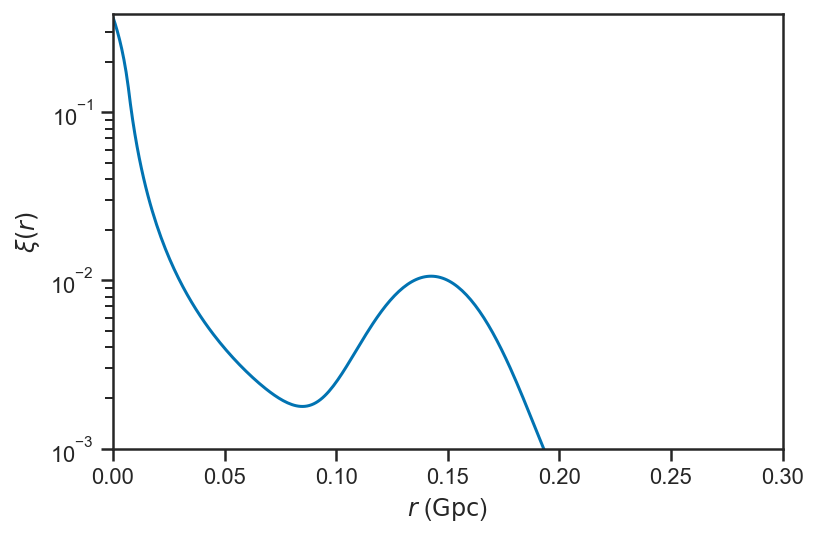

In [70]:
rs = linspace(0, 1.0, 1024)
xi_rs = xi(rs)
plot(rs, xi_rs)

axis(xmin=0, xmax=0.3, ymin=1e-3)

yscale('log')
xlabel(r'$r$ ($\mathrm{Gpc}$)')
ylabel(r'$\xi(r)$')

k8 = 2*pi/(8/0.7/1000) # 1/Gpc
sigma8 = 2/pi*k8**3*trapz(xi_rs*sin(k8*rs)/k8*rs, rs)
print('sigma 8 = {:.2f}'.format(sigma8))

Here we reproducably draw from this GP.  We draw a grid of double the number of points *uniformly*, compute a draw from the GP for the density at each point, and rejection sample.

In [71]:
rstate = np.random.get_state()
factor = 3
try:
    np.random.seed(1363279349)

    Ndraw = factor*Ndet
    rs = cbrt(dC_range**3*rand(Ndraw))
    cos_thetas = np.random.uniform(low=-1, high=1, size=Ndraw)
    sin_thetas = sqrt(1-cos_thetas*cos_thetas)
    phis = np.random.uniform(low=0, high=2*pi, size=Ndraw)
    
    pts = column_stack((rs*cos(phis)*sin_thetas,
                        rs*sin(phis)*sin_thetas,
                        rs*cos_thetas))
    
    rs = np.sqrt(np.sum(np.square(pts[:,newaxis,:] - pts[newaxis,:,:]), axis=2))
    C = xi(rs)
    L = np.linalg.cholesky(C)
    
    ns = exp(log(n0) + np.dot(L, randn(Ndraw)))
    ns /= np.max(ns)
    pts = pts[rand(Ndraw) < ns, :]
    print('Drew {:d}'.format(pts.shape[0]))
finally:
    np.random.set_state(rstate)

/Users/wfarr/anaconda3/envs/GWBAO/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in power
  from ipykernel import kernelapp as app


Drew 1724


We make our points into a pandas data frame so that Seaborn is happy plotting it:

In [72]:
pts = pd.DataFrame(data=pts, columns=['x', 'y', 'z'])

Here's what it looks like---pretty uniform, but to my eye there seem to be characteristic scaled gaps that are of order 100 Mpc.

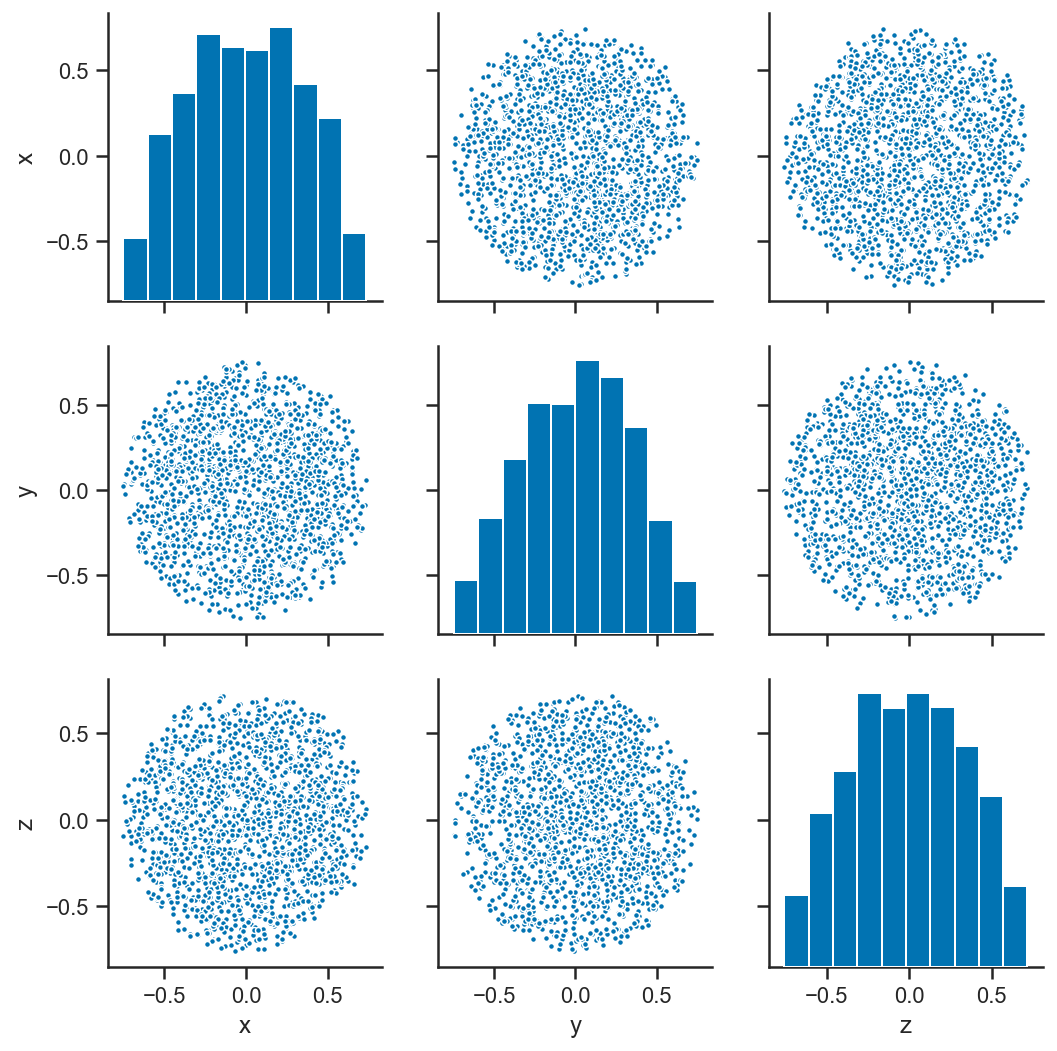

In [73]:
sns.pairplot(pts, markers='.')

In [39]:
with h5py.File('comoving-positions.h5', 'w') as out:
    out.create_dataset('pos', data=pts, compression='gzip', shuffle=True)

In [40]:
def normalize(v):
    return v / np.sqrt(np.sum(v*v))

def draw_observation(xyz):
    x, y, z = xyz
    d = np.sqrt(np.sum(xyz*xyz))
    
    rshift = cosmo.z_at_value(Planck15.comoving_distance, d*u.Gpc)
    srshift = (0.017*rshift + 0.012)*rshift
    sd = Planck15.comoving_distance(rshift + srshift).to(u.Gpc).value - d
    
    rhat = normalize(xyz)
    
    v = np.random.randn(3)
    vp = v - np.dot(rhat, v)*rhat
    xhat = normalize(vp)
    yhat = np.cross(xhat, rhat)
    
    T_rxy_to_xyz = np.row_stack((rhat, xhat, yhat))
    
    sigma_r = sd
    sigma_x = exp(log(3*pi/180) + 1.0*np.random.randn())*d
    sigma_y = exp(log(3*pi/180) + 1.0*np.random.randn())*d
    
    Sigma = np.dot(T_rxy_to_xyz, np.dot(np.diag((sigma_r*sigma_r, sigma_x*sigma_x, sigma_y*sigma_y)), T_rxy_to_xyz.T))
    
    xyz_obs = xyz + np.dot(np.linalg.cholesky(Sigma), randn(3))
    
    return (xyz_obs, Sigma)

In [41]:
rstate = np.random.get_state()
try:
    np.random.seed(32118314)

    pts_obs = pd.DataFrame(columns=['x', 'y', 'z'])
    Sigma_obs = []
    for i, pt in tqdm(pts.iterrows(), total=pts.shape[0]):
        pt_obs, Sigma = draw_observation(pt)
        pts_obs = pts_obs.append(pt_obs)
        Sigma_obs.append(Sigma)
    Sigma_obs = array(Sigma_obs)
    
finally:
    np.random.set_state(rstate)

In [42]:
with h5py.File('comoving-observations.h5', 'w') as out:
    out.create_dataset('pos', data=pts_obs, compression='gzip', shuffle=True)
    out.create_dataset('Sigma_pos', data=Sigma_obs, compression='gzip', shuffle=True)

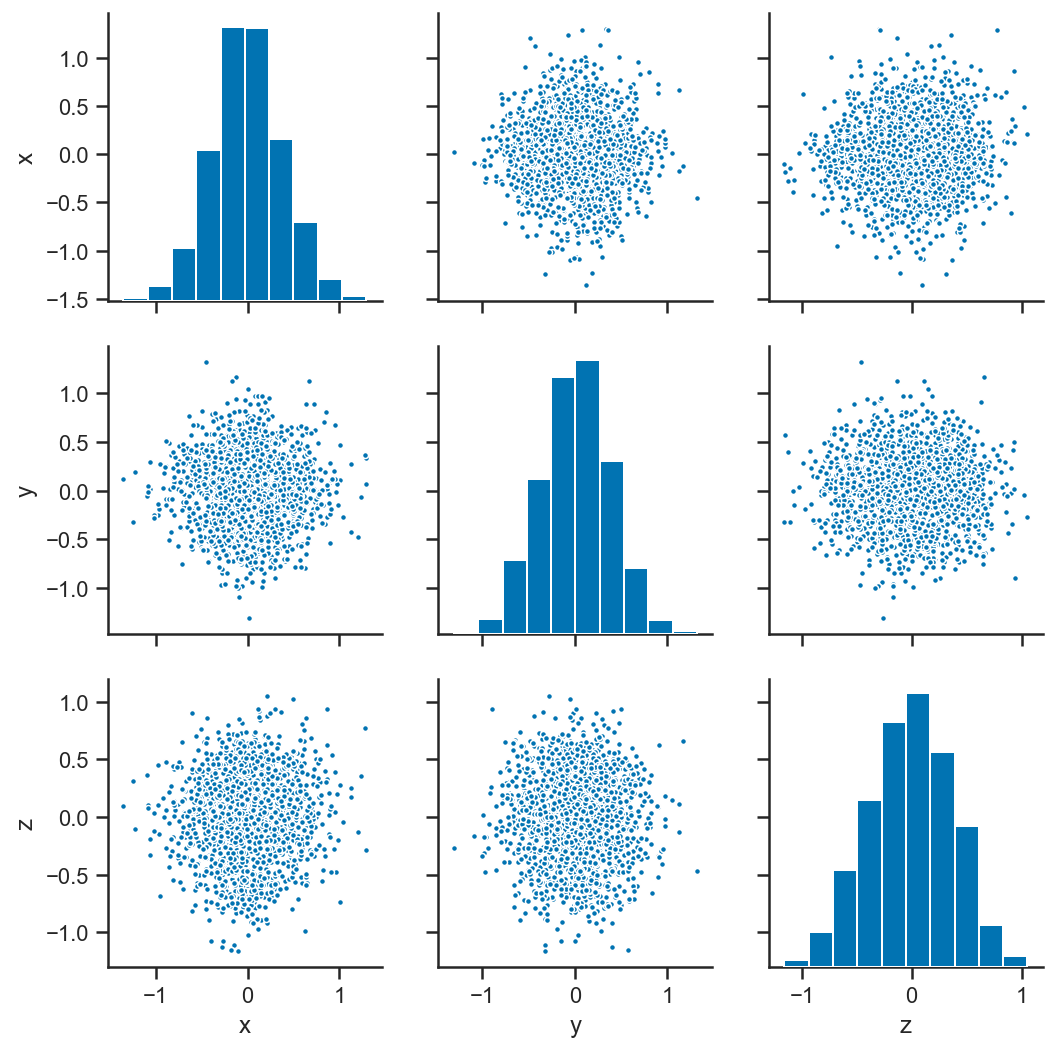

In [43]:
sns.pairplot(pts_obs, markers='.')

## A Landy Szalay Like Estimator

First we compute a L-S-like estimator, with no uncertainty about the positions of the galaxies.

In [44]:
def counts_in_bins(xs, ys, bins, auto=False):
    n = xs.shape[0]
    assert n == ys.shape[0]
    if auto:
        i1, i2 = tril_indices(n, 1)
        rs = xs[i1,:] - ys[i2,:]
        r2s = np.sum(rs*rs, axis=1)
    else:
        rs = xs[:,newaxis,:] - ys[newaxis,:,:]
        r2s = np.sum(rs*rs, axis=2)
        
    return histogram(r2s.flatten(), bins*bins)[0]

In [45]:
h = 0.7
rbins = exp(arange(log(0.075), log(0.25), 0.05))
nb = rbins.shape[0]-1
rbins_cent = 0.5*(rbins[1:] + rbins[:-1])
rbins

array([0.075     , 0.07884533, 0.08288782, 0.08713757, 0.09160521,
       0.09630191, 0.10123941, 0.10643007, 0.11188685, 0.11762341,
       0.1236541 , 0.12999398, 0.13665891, 0.14366556, 0.15103145,
       0.158775  , 0.16691557, 0.17547351, 0.18447023, 0.19392822,
       0.20387114, 0.21432383, 0.22531245, 0.23686447, 0.24900877])

In [46]:
def draw_uniform_observation(N, obs_scatter=True):
    pts = random.uniform(low=-dC_range, high=dC_range, size=(5*N, 3))
    r2s = np.sum(pts*pts, axis=1)
    sel = r2s < dC_range*dC_range
    pts = pts[sel, :]
    pts = pts[:N, :]
    
    if obs_scatter:
        return array([draw_observation(pt)[0] for pt in pts])
    else:
        return pts

In [47]:
Gp = zeros(nb)
N = pts.shape[0]
Niter = 100
for i in tqdm(range(Niter)):
    random_obs = draw_uniform_observation(N, obs_scatter=False)
    cts = counts_in_bins(random_obs, random_obs, rbins, auto=True)

    Gp += cts / float(N*(N-1)/2)
Gp /= float(Niter)

In [83]:
with h5py.File('comoving-positions.h5', 'r') as f:
    obs_pts = array(f['pos'])
Nobs = obs_pts.shape[0]
DD = counts_in_bins(obs_pts, obs_pts, rbins, auto=True) / float(Nobs*(Nobs-1)/2)

In [84]:
DR = zeros(nb)
for i in tqdm(range(Niter)):
    random_obs = draw_uniform_observation(N, obs_scatter=False)
    DR += counts_in_bins(obs_pts, random_obs, rbins) / float(Nobs*N)
DR /= float(Niter)

In [85]:
xi_est_noscatter = (DD - 2*DR + Gp)/Gp
sigma_xi_noscatter = abs(1 + xi_est_noscatter)*sqrt(2/(N*(N-1)*Gp))

Here we fit for the optimal amplitude of the BAO peak, fixing its shape and location:

In [86]:
Amax = sum(xi_est_noscatter*xi_bao(rbins_cent) / sigma_xi_noscatter**2) / sum(xi_bao(rbins_cent)*xi_bao(rbins_cent)/sigma_xi_noscatter**2)
sigma_A = 1/sqrt(sum(xi_bao(rbins_cent)**2/sigma_xi_noscatter**2))

In [87]:
Amax, sigma_A

(4.905336728040068, 1.2643479232966564)

That doesn't look very encouraging....

Text(0, 0.5, '$\\xi(r)$')

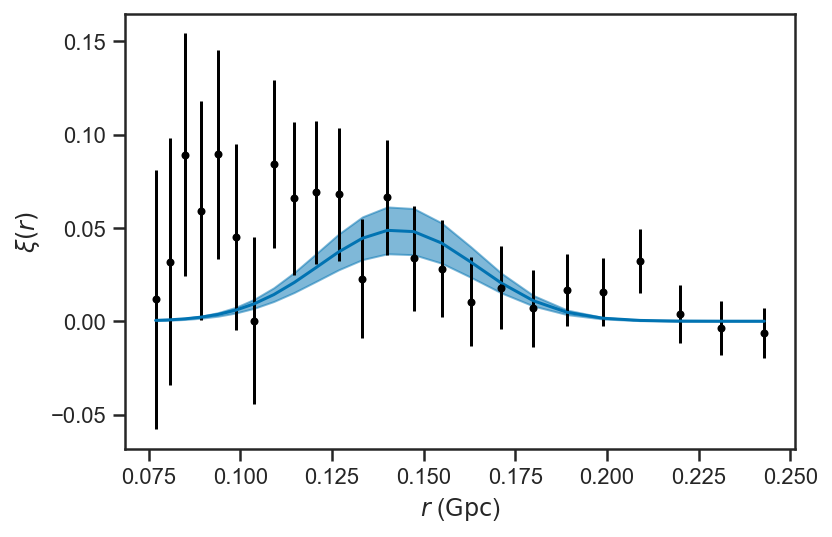

In [88]:
errorbar(rbins_cent, xi_est_noscatter, yerr=sigma_xi_noscatter, fmt='.', color='k')
plot(rbins_cent, Amax*xi_bao(rbins_cent), color=sns.color_palette()[0])
fill_between(rbins_cent, (Amax+sigma_A)*xi_bao(rbins_cent), (Amax-sigma_A)*xi_bao(rbins_cent), color=sns.color_palette()[0], alpha=0.5)
xlabel(r'$r$ ($\mathrm{Gpc}$)')
ylabel(r'$\xi(r)$')